In [6]:
# referensi: https://www.kaggle.com/code/paulojunqueira/mnist-with-pytorch-and-transfer-learning-timm

import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset,ConcatDataset,DataLoader
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class MNISTdataset(Dataset):
    """V2"""
    def __init__(self, data, transform = None):
        
        self.X = (data.drop('label', axis =1).values/255).reshape((-1, 28, 28,1))
        self.y = data['label'].values.reshape(-1,1)
        self.n_samples = data.shape[0]
        
        self.transform = transform 
    
    def __getitem__(self, index):
        X,y = self.X[index], self.y[index]
        
        if self.transform:
            X  = self.transform(X)
            
        return (X,y)
        
    def __len__(self):
        return self.n_samples

In [8]:
train_df = pd.read_csv('dataHandSign/archive/sign_mnist_train/sign_mnist_train.csv',dtype=np.float32)
compose_agu_1 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(300,350), fill=(0,))])
compose_agu_2 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(0,45), fill=(0,))])
compose_original = transforms.Compose([transforms.ToTensor()])

In [9]:
dataset_original = MNISTdataset(train_df,transform = compose_original)
dataset_aug_1 = MNISTdataset(train_df,transform = compose_agu_1)
dataset_aug_2 = MNISTdataset(train_df,transform = compose_agu_2)
increased_dataset = ConcatDataset([dataset_aug_1,dataset_aug_2,dataset_original])


In [10]:
#Spliting Data
val_size = 0.3
batch_size = 128

X_train, X_val, = train_test_split(increased_dataset, test_size = val_size, random_state = 666)

# Creating Datasets Loaders
train_loader = DataLoader(X_train, batch_size  = batch_size,  shuffle = True)
val_loader = DataLoader(X_val, batch_size  = batch_size,  shuffle = True)

C:\Users\giosp\AppData\Local\Temp\ipykernel_17396\3403339041.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[0,i].set_title(int(y))
C:\Users\giosp\AppData\Local\Temp\ipykernel_17396\3403339041.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[1,i].set_title(int(y))


Text(0, 0.5, 'Original Images')

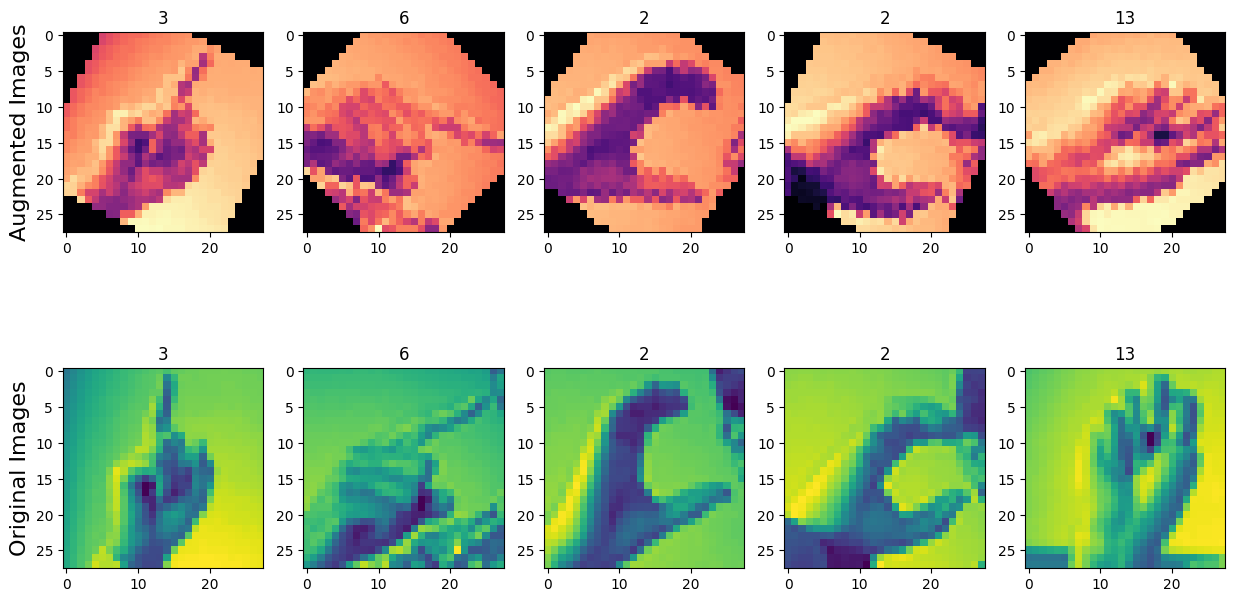

In [11]:
#Visualizing some examples in the training dataset X
fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
for i in range(5):
    image, y = dataset_aug_1.__getitem__(i)
    ax[0,i].imshow(image.squeeze(), cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
    ax[0,i].set_title(int(y))
    
    image, y = dataset_original.__getitem__(i)
    ax[1,i].imshow(image.squeeze(), cmap="viridis") # Squeeze removes length (1,28,28) -> (28,28)
    ax[1,i].set_title(int(y))

ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})
ax[1,0].set_ylabel('Original Images', fontdict= {'fontsize':16})

Model

In [12]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Training Function
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def train_(model, optmizer, loss_func, train_loader, device):
    """Function to train the model"""
    train_loss = 0.0
    train_correct = 0
    size_sampler = len(train_loader.sampler)
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Pushing to device (cuda or CPU)
        images, labels = images.to(device), labels.to(device)
        
        #zeroing gradiants
        optmizer.zero_grad()
        
        #feedfoard
        y_hat = model(images)
        
        #Compute loss 
        loss = loss_func(y_hat, labels.long().squeeze())
        
        #Compute backpropagation
        loss.backward()
        
        #updating weights
        optmizer.step()
        
        # loss and correct values compute
        train_loss +=loss.item() * images.size(0)
        _ , pred = torch.max(y_hat.data, 1)
        train_correct +=sum(pred == labels.long().squeeze()).sum().item()
        
    return np.round(train_loss/size_sampler,4), np.round(train_correct*100./size_sampler,3)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Validation Function
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def validation_(model, loss_func,val_loader, device):
    val_loss = 0.0
    val_correct = 0
    size_sampler = len(val_loader.sampler)
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):

            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)
            loss = loss_func(y_hat, labels.long().squeeze())
            
            val_loss +=loss.item() * images.size(0)
            _ , pred = torch.max(y_hat.data, 1)
            val_correct +=(pred == labels.long().squeeze()).sum().item()
        
    return np.round(val_loss/size_sampler,4), np.round(val_correct*100./size_sampler,3)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Main Training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def train_model(model,optmizer, loss_func,scheduler, train_loader, val_loader, epochs, device, log = True):
    
    best_acc = 0
    
    
    print('Initializing Training...')
    
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    
    for i in range(epochs):
        
        train_loss, train_acc=  train_(model, optmizer, loss_func, train_loader,device)
        val_loss, val_acc = validation_(model, loss_func,val_loader, device)
        
        scheduler.step()
        
        if val_acc > best_acc:
            print(f'>> Saving Best Model with Val Acc: Old: {best_acc} | New: {val_acc}')
            best_model = copy.deepcopy(model)
            best_acc = val_acc
        
        
        if log and ((i+1)%2 == 0):
            print(f'> Epochs: {i+1}/{epochs} - Train Loss: {train_loss} - Train Acc: {train_acc} - Val Loss: {val_loss} - Val Acc: {val_acc}')
        
        #Saving infos on a history dict
        for key, value in zip(history, [train_loss,val_loss,train_acc,val_acc]):
            history[key].append(value)
    
    
    
    print('...End Traing')
            
    return history,best_model

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Ploting graphics
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def plot_history(history):
    
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    
    #Loss
    sns.lineplot(data = history['train_loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('Loss')
    #Accuracy
    sns.lineplot(data = history['train_acc'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history['val_acc'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title('Accuracy')

Initializing Training...
>> Saving Best Model with Val Acc: Old: 0 | New: 94.796
>> Saving Best Model with Val Acc: Old: 94.796 | New: 97.345
> Epochs: 2/30 - Train Loss: 0.0979 - Train Acc: 96.703 - Val Loss: 0.0788 - Val Acc: 97.345
>> Saving Best Model with Val Acc: Old: 97.345 | New: 97.823
>> Saving Best Model with Val Acc: Old: 97.823 | New: 98.871
> Epochs: 4/30 - Train Loss: 0.0372 - Train Acc: 98.782 - Val Loss: 0.0351 - Val Acc: 98.871
>> Saving Best Model with Val Acc: Old: 98.871 | New: 99.102
>> Saving Best Model with Val Acc: Old: 99.102 | New: 99.858
> Epochs: 6/30 - Train Loss: 0.0038 - Train Acc: 99.901 - Val Loss: 0.0044 - Val Acc: 99.858
>> Saving Best Model with Val Acc: Old: 99.858 | New: 99.911
>> Saving Best Model with Val Acc: Old: 99.911 | New: 99.939
> Epochs: 8/30 - Train Loss: 0.0004 - Train Acc: 99.998 - Val Loss: 0.002 - Val Acc: 99.939
> Epochs: 10/30 - Train Loss: 0.0002 - Train Acc: 100.0 - Val Loss: 0.0018 - Val Acc: 99.939
>> Saving Best Model with Va

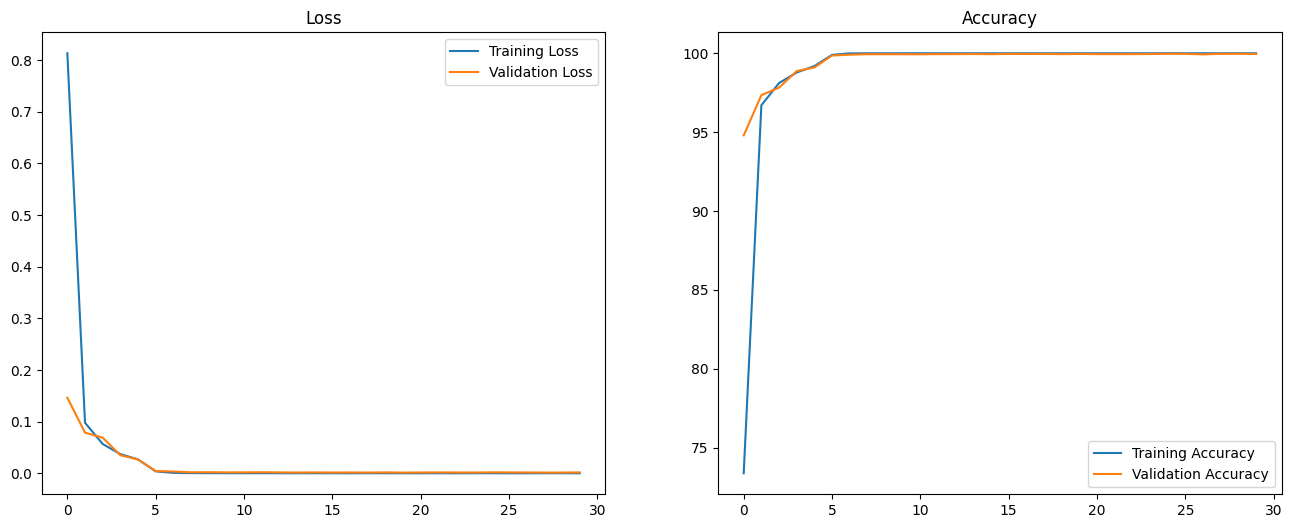

In [13]:
class confiFile():
    """Configuration class for easy parametrization"""
    
    #Pretrained model with timm
    model = 'resnet50'
    epochs = 30
    
    in_chans = 1
    num_classes = 26
    learning_rate = 1e-3
    
    val_size = 0.3
    batch_size = 128
    
CFG = confiFile()
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Execute training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

model = timm.create_model(CFG.model, 
                          pretrained = False,
                          in_chans = CFG.in_chans, 
                          num_classes = CFG.num_classes)

model = model.to(device)

# # Same as using the model.fc (for resnet only) but easier as it can change in other models
# print(model.get_classifier())

# #checking the global pooling from timm
# print(model.global_pool)


optmizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
loss_func =  nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optmizer, step_size=5, gamma=0.1)

history,best_model = train_model(model = model, 
                    optmizer = optmizer, 
                    loss_func = loss_func,
                    scheduler = scheduler,
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = CFG.epochs,
                    device = device)

#ploting results
plot_history(history)

In [14]:
print(timm.list_models(pretrained=True))

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

Initializing Training...
>> Saving Best Model with Val Acc: Old: 0 | New: 86.548
>> Saving Best Model with Val Acc: Old: 86.548 | New: 92.675
> Epochs: 2/30 - Train Loss: 0.2686 - Train Acc: 90.681 - Val Loss: 0.2157 - Val Acc: 92.675
>> Saving Best Model with Val Acc: Old: 92.675 | New: 96.451
>> Saving Best Model with Val Acc: Old: 96.451 | New: 96.734
> Epochs: 4/30 - Train Loss: 0.1086 - Train Acc: 96.425 - Val Loss: 0.1033 - Val Acc: 96.734
>> Saving Best Model with Val Acc: Old: 96.734 | New: 96.916
>> Saving Best Model with Val Acc: Old: 96.916 | New: 99.595
> Epochs: 6/30 - Train Loss: 0.0151 - Train Acc: 99.558 - Val Loss: 0.0135 - Val Acc: 99.595
>> Saving Best Model with Val Acc: Old: 99.595 | New: 99.688
>> Saving Best Model with Val Acc: Old: 99.688 | New: 99.729
> Epochs: 8/30 - Train Loss: 0.0031 - Train Acc: 99.917 - Val Loss: 0.0086 - Val Acc: 99.729
>> Saving Best Model with Val Acc: Old: 99.729 | New: 99.781
> Epochs: 10/30 - Train Loss: 0.002 - Train Acc: 99.95 - Va

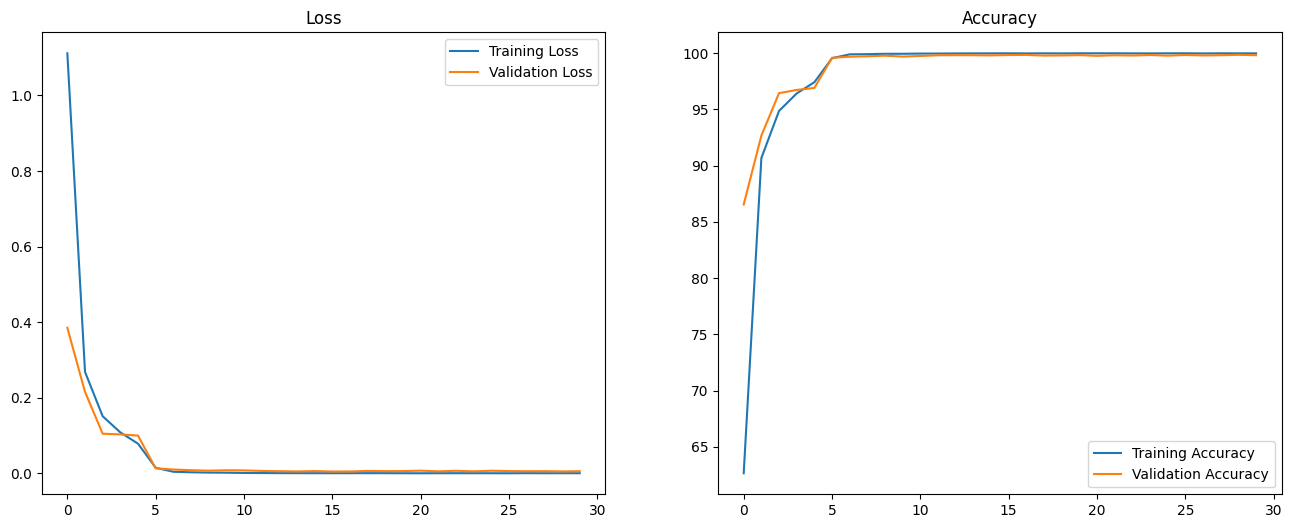

In [15]:
class confiFile2():
    """Configuration class for easy parametrization"""
    
    #Pretrained model with timm
    model = 'ghostnet_100'
    epochs = 30
    
    in_chans = 1
    num_classes = 26
    learning_rate = 1e-3
    
    val_size = 0.3
    batch_size = 128
    
CFG2 = confiFile2()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Execute training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

model = timm.create_model(CFG2.model, 
                          pretrained = False,
                          in_chans = CFG2.in_chans, 
                          num_classes = CFG2.num_classes)

model = model.to(device)

# # Same as using the model.fc (for resnet only) but easier as it can change in other models
# print(model.get_classifier())

# #checking the global pooling from timm
# print(model.global_pool)


optmizer = optim.Adam(model.parameters(), lr = CFG2.learning_rate)
loss_func =  nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optmizer, step_size=5, gamma=0.1)

history,best_model = train_model(model = model, 
                    optmizer = optmizer, 
                    loss_func = loss_func,
                    scheduler = scheduler,
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = CFG.epochs,
                    device = device)

#ploting results
plot_history(history)


Initializing Training...
>> Saving Best Model with Val Acc: Old: 0 | New: 43.816
>> Saving Best Model with Val Acc: Old: 43.816 | New: 68.09
> Epochs: 2/30 - Train Loss: 1.2545 - Train Acc: 58.883 - Val Loss: 0.9443 - Val Acc: 68.09
>> Saving Best Model with Val Acc: Old: 68.09 | New: 81.477
>> Saving Best Model with Val Acc: Old: 81.477 | New: 88.009
> Epochs: 4/30 - Train Loss: 0.38 - Train Acc: 86.901 - Val Loss: 0.3472 - Val Acc: 88.009
>> Saving Best Model with Val Acc: Old: 88.009 | New: 91.315
>> Saving Best Model with Val Acc: Old: 91.315 | New: 95.593
> Epochs: 6/30 - Train Loss: 0.0909 - Train Acc: 97.032 - Val Loss: 0.133 - Val Acc: 95.593
>> Saving Best Model with Val Acc: Old: 95.593 | New: 95.775
>> Saving Best Model with Val Acc: Old: 95.775 | New: 96.07
> Epochs: 8/30 - Train Loss: 0.0465 - Train Acc: 98.47 - Val Loss: 0.119 - Val Acc: 96.07
>> Saving Best Model with Val Acc: Old: 96.07 | New: 96.544
>> Saving Best Model with Val Acc: Old: 96.544 | New: 96.726
> Epochs:

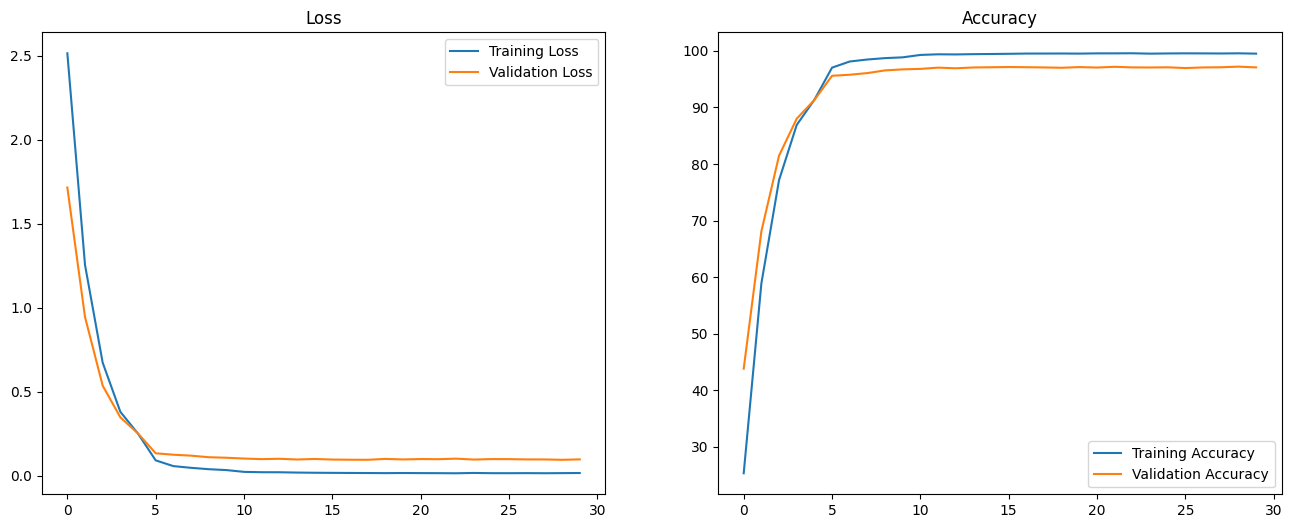

In [16]:
class confiFile3():
    """Configuration class for easy parametrization"""
    
    #Pretrained model with timm
    model = 'mobilenetv3_small_100'
    epochs = 30
    
    in_chans = 1
    num_classes = 26
    learning_rate = 1e-3
    
    val_size = 0.3
    batch_size = 128
    
CFG3 = confiFile3()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Execute training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

model = timm.create_model(CFG3.model, 
                          pretrained = False,
                          in_chans = CFG3.in_chans, 
                          num_classes = CFG3.num_classes)

model = model.to(device)

# # Same as using the model.fc (for resnet only) but easier as it can change in other models
# print(model.get_classifier())

# #checking the global pooling from timm
# print(model.global_pool)


optmizer = optim.Adam(model.parameters(), lr = CFG3.learning_rate)
loss_func =  nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optmizer, step_size=5, gamma=0.1)

history,best_model = train_model(model = model, 
                    optmizer = optmizer, 
                    loss_func = loss_func,
                    scheduler = scheduler,
                    train_loader = train_loader,
                    val_loader = val_loader,
                    epochs = CFG.epochs,
                    device = device)

#ploting results
plot_history(history)
